# ++ Carregar dados históricos da Bovespa em Dataframe para análise ++

In [1]:
import time
time.asctime( time.localtime(time.time()) )

'Tue Sep  3 15:47:53 2024'

In [2]:
import pandas as pd
from datetime import date, datetime, timedelta
from ipywidgets import IntProgress
import ipywidgets as widgets
import json
pd.__version__

'1.3.4'

In [3]:
from IPython.display import FileLink, FileLinks, display, clear_output, Markdown
FileLink('Resultados.ipynb')

C:\Users\F0435280\OneDrive - Banco do Brasil S.A\Área de Trabalho\Alexandre\StockManager-main\Resultados.ipynb

In [4]:
# Setando opção do Pandas para mostrar todas as linhas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Setando separador de milhar
pd.options.display.float_format = '{:,.2f}'.format

In [5]:
from pacote.functions import *

In [6]:
ano = time.localtime().tm_year
if time.localtime().tm_mon < 3:
    str_ano, str_nov_ant, str_dez_ant = f'A{ano}', f'M11{ano-1}', f'M12{ano-1}'
    LISTA_ARQUIVOS = [str_ano, str_nov_ant, str_dez_ant]
else:
    str_ano = f'A{ano}'
    LISTA_ARQUIVOS = [str_ano]

In [7]:
df = carrega_dados(LISTA_ARQUIVOS)

In [8]:
# Monday is 0 and Sunday is 6.
dia_semana  = datetime.today().weekday()
ajuste_dias = -3 if dia_semana == 0 else -1
dt_esperado_ult = (datetime.today() + timedelta(days=ajuste_dias)).strftime('%Y-%m-%d')
dt_max = str(df["dtPregao"].max()).split()[0]

if dt_esperado_ult == dt_max:
    font_color="alert-success"
    a = "Atualizado!"
else:
    font_color="alert-danger"
    a = "Desatualizado!!! Última data " + str(dt_max)
def printmd(string):
    display(Markdown(string))

In [9]:
#  df_n_dias | vol | col_pc | pc_min | avg_vr_fech

style, layout, max_count, parm_vol = {'description_width':'initial'}, {'width':'400px'}, 7, 6000000
bar = IntProgress(min=0, max=max_count, style=style, layout=layout) # instantiate the bar
display(bar) # display the bar

d25 = monta_tabela(monta_df_periodos(df, 25), parm_vol, '1.0%', 24, 1, bar)
d20 = monta_tabela(monta_df_periodos(df, 20), parm_vol, '1.0%', 19, 1, bar)
d15 = monta_tabela(monta_df_periodos(df, 15), parm_vol, '1.0%', 14, 1, bar)
d10 = monta_tabela(monta_df_periodos(df, 10), parm_vol, '1.0%', 9, 1, bar)
d05 = monta_tabela(monta_df_periodos(df, 5), parm_vol, '1.0%', 5, 1, bar)
d04 = monta_tabela(monta_df_periodos(df, 4), parm_vol, '1.0%', 4, 1, bar)
d03 = monta_tabela(monta_df_periodos(df, 3), parm_vol, '1.0%', 3, 1, bar)
merge1 = pd.merge(d25['cdAcao'], d20['cdAcao'], how ='inner', on =['cdAcao'])
merge2 = pd.merge(merge1, d15['cdAcao'], how ='inner', on =['cdAcao'])
merge3 = pd.merge(merge2, d10['cdAcao'], how ='inner', on =['cdAcao'])
merge_final = pd.merge(merge3, d05['cdAcao'], how ='inner', on =['cdAcao'])
if merge_final.empty:
    merge_final = ">> Sem ações boas em todo o período <<"

IntProgress(value=0, layout=Layout(width='400px'), max=7, style=ProgressStyle(description_width='initial'))

In [10]:
df_button = d04

button0 = widgets.Button(description=f'{"0-"}{df_button["cdAcao"].iloc[0]}') if df_button["cdAcao"].size > 0 else None
button1 = widgets.Button(description=f'{"1-"}{df_button["cdAcao"].iloc[1]}') if df_button["cdAcao"].size > 1 else None
button2 = widgets.Button(description=f'{"2-"}{df_button["cdAcao"].iloc[2]}') if df_button["cdAcao"].size > 2 else None
button3 = widgets.Button(description=f'{"3-"}{df_button["cdAcao"].iloc[3]}') if df_button["cdAcao"].size > 3 else None
button4 = widgets.Button(description=f'{"4-"}{df_button["cdAcao"].iloc[4]}') if df_button["cdAcao"].size > 4 else None
button5 = widgets.Button(description=f'{"5-"}{df_button["cdAcao"].iloc[5]}') if df_button["cdAcao"].size > 5 else None
button6 = widgets.Button(description=f'{"6-"}{df_button["cdAcao"].iloc[6]}') if df_button["cdAcao"].size > 6 else None
output = widgets.Output()

def on_button_clicked(b):
    with output:
        clear_output()
        index = int(b.description[0])
        display(consulta_acao_formatada(df, df_button['cdAcao'].iloc[index])[:-1])

lista_buttons = []
if button0:
    button0.on_click(on_button_clicked)
    lista_buttons.append(button0)
if button1:
    button1.on_click(on_button_clicked)
    lista_buttons.append(button1)
if button2:
    button2.on_click(on_button_clicked)
    lista_buttons.append(button2)
if button3:
    button3.on_click(on_button_clicked)
    lista_buttons.append(button3)
if button4:
    button4.on_click(on_button_clicked)
    lista_buttons.append(button4)
if button5:
    button5.on_click(on_button_clicked)
    lista_buttons.append(button5)
if button6:
    button6.on_click(on_button_clicked)
    lista_buttons.append(button6)

In [11]:
printmd(f'**<div class={font_color}>Arquivo {a}</div>**')

**<div class=alert-success>Arquivo Atualizado!</div>**

### 25 dias, order by 1%

In [12]:
d25 if not d25.empty else print('<< Sem ações boas para 25 dias >>')

,cdAcao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,Soma,AvgVol,AvgVrFech,AvgPcAbert
1909,SEQL3,24,24,23,23,21,20,135,"12,574,124.16",5.92,1.17


### 20 dias, order by 1%

In [13]:
d20 if not d20.empty else print('<< Sem ações boas para 20 dias >>')

,cdAcao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,Soma,AvgVol,AvgVrFech,AvgPcAbert
1880,SEQL3,19,19,18,18,17,17,108,"15,427,888.70",6.39,1.45
1310,LIGT3,20,20,18,18,13,12,101,"8,965,894.15",5.44,0.06


### 15 dias, order by 1%

In [14]:
d15 if not d15.empty else print('<< Sem ações boas para 15 dias >>')

,cdAcao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,Soma,AvgVol,AvgVrFech,AvgPcAbert
1265,LIGT3,15,15,14,14,11,10,79,"10,680,350.73",5.85,0.14
1815,SEQL3,14,14,13,13,12,12,78,"11,477,170.93",6.13,0.49
60,AERI3,15,14,12,11,10,10,72,"6,412,437.20",9.63,0.99


### 10 dias, order by 1%

In [15]:
d10 if not d10.empty else print('<< Sem ações boas para 10 dias >>')

,cdAcao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,Soma,AvgVol,AvgVrFech,AvgPcAbert
108,AMER3,10,10,10,10,10,10,60,"74,019,696.00",3.32,"1,070.22"
1213,LIGT3,10,10,9,9,6,5,49,"12,286,975.30",6.24,0.24
1743,SEQL3,9,9,8,8,7,7,48,"7,658,155.70",6.13,0.83
1977,VIVA3,9,9,5,4,2,1,30,"88,764,188.40",26.68,0.35


### 5 dias, order by 1%

In [16]:
d05

,cdAcao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,Soma,AvgVol,AvgVrFech,AvgPcAbert
102,AMER3,5,5,5,5,5,5,30,"107,626,734.00",6.57,"2,140.44"
1515,RCSL3,5,5,5,5,5,5,30,"8,192,613.20",4.73,1.32
1134,LIGT3,5,5,4,4,2,1,21,"6,557,801.80",6.32,0.24
37,AAPL34,5,5,4,1,1,1,17,"12,439,786.88",63.70,1.25


In [17]:
d04

,cdAcao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,Soma,AvgVol,AvgVrFech,AvgPcAbert
98,AMER3,4,4,4,4,4,4,24,"108,965,596.00",6.46,0.55
1479,RCSL3,4,4,4,4,4,4,24,"8,324,897.50",4.91,1.19
1105,LIGT3,4,4,4,4,2,1,19,"7,504,139.50",6.38,0.07
859,GOGL34,4,4,3,2,1,1,15,"13,252,766.33",76.16,0.59
1148,M1TA34,4,4,2,2,1,1,14,"8,069,732.24",103.48,0.83
34,AAPL34,4,4,3,1,1,1,14,"13,699,346.99",63.96,1.57


In [18]:
d03

,cdAcao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,Soma,AvgVol,AvgVrFech,AvgPcAbert
97,AMER3,3,3,3,3,3,3,18,"110,669,196.67",6.25,0.45
1438,RCSL3,3,3,3,3,3,3,18,"10,194,085.67",5.19,1.01
94,AMBP3,3,3,2,2,2,2,14,"43,231,712.00",69.25,0.10
1553,SEQL3,3,3,2,2,2,2,14,"7,539,572.00",6.14,0.38
834,GOGL34,3,3,3,2,1,1,13,"14,916,690.99",76.40,0.70
1072,LIGT3,3,3,3,3,1,0,13,"6,839,062.67",6.42,0.53
124,AURA33,3,3,2,2,1,1,12,"7,880,461.94",18.39,0.13
1113,M1TA34,3,3,2,2,1,1,12,"8,766,825.20",103.88,0.89
1212,NASD11,3,3,2,2,1,1,12,"14,422,149.88",15.32,1.03
33,AAPL34,3,3,2,1,1,1,11,"15,836,424.53",64.32,1.76


In [19]:
printmd(f'**<div class={font_color}>Status {a}</div>**')

**<div class=alert-success>Status Atualizado!</div>**

## Consulta ação específica

In [20]:
consulta_acao_formatada(df, "AERI3")[:-1]

,cdAcao,dtPregao,vrFech,vrVolume,vrMaxDia,vrMinDia,vrAbert,pcVar,pcMaxDia,pcMinDia,pcAbert,i05,i10,i15,i20,i25,i30
283082,AERI3,2024-09-02,11.38,"10,506,711",12.40,11.00,12.40,-5.95%,2.48%,-9.09%,2.48%,1,1,1,1,,
281398,AERI3,2024-08-30,12.10,"19,077,701",12.10,9.95,10.28,20.16%,20.16%,-1.19%,2.09%,1,1,1,1,1,1
279953,AERI3,2024-08-29,10.07,"3,311,294",10.36,9.80,10.28,-2.23%,0.58%,-4.85%,-0.19%,1,,,,,
278171,AERI3,2024-08-28,10.30,"4,995,815",10.52,9.63,9.86,3.41%,5.62%,-3.31%,-1.00%,1,1,1,1,1,1
276675,AERI3,2024-08-27,9.96,"4,869,534",10.07,8.77,8.84,13.70%,14.95%,0.11%,0.91%,1,1,1,1,1,1
274671,AERI3,2024-08-26,8.76,"4,454,775",9.50,8.66,8.93,-1.57%,6.74%,-2.70%,0.34%,1,1,1,1,1,1
273030,AERI3,2024-08-23,8.90,"3,751,905",9.34,8.16,8.16,9.74%,15.17%,0.62%,0.62%,1,1,1,1,1,1
271359,AERI3,2024-08-22,8.11,"3,322,000",9.35,8.11,9.35,-12.13%,1.30%,-12.13%,1.30%,1,1,,,,
269943,AERI3,2024-08-21,9.23,"1,699,315",9.78,9.13,9.39,-0.65%,5.27%,-1.72%,1.08%,1,1,1,1,1,1
268020,AERI3,2024-08-20,9.29,"2,895,224",9.47,9.06,9.40,-0.85%,1.07%,-3.31%,0.32%,1,1,,,,


In [61]:
df_temp = consulta_acao(df, "AMER3")[:-1]
df_temp = df_temp.replace("", 0)

In [62]:
# df_temp['pcVar'].where(df_temp['pcVar'] > 10, 100, inplace=True)
df_temp['pcVar'].values[df_temp['pcVar'].values > 1000] = -999
df_temp

,cdAcao,dtPregao,vrFech,vrVolume,vrMaxDia,vrMinDia,vrAbert,pcVar,pcMaxDia,pcMinDia,pcAbert,i05,i10,i15,i20,i25,i30
283393,AMER3,2024-09-02,6.98,"119,809,131",7.25,5.77,5.77,20.97,25.65,0.00,0.00,1,1,1,1,1,1
281730,AMER3,2024-08-30,5.77,"64,471,397",6.22,5.76,6.09,-3.83,3.67,-4.00,1.50,1,1,1,1,1,1
280056,AMER3,2024-08-29,6.00,"147,727,062",7.33,6.00,7.09,-15.49,3.24,-15.49,-0.14,1,1,1,1,1,1
278381,AMER3,2024-08-28,7.10,"103,854,794",7.58,6.72,7.06,1.43,8.29,-4.00,0.86,1,1,1,1,1,1
276731,AMER3,2024-08-27,7.00,"102,271,286",7.65,5.40,5.40,-999.00,"15,200.00","10,700.00","10,700.00",1,1,1,1,1,1
275030,AMER3,2024-08-26,0.05,"22,206,040",0.07,0.05,0.06,-16.67,16.67,-16.67,0.00,1,1,1,1,1,1
273342,AMER3,2024-08-23,0.06,"53,941,352",0.08,0.05,0.07,-14.29,14.29,-28.57,0.00,1,1,1,1,1,1
271674,AMER3,2024-08-22,0.07,"46,133,251",0.09,0.07,0.08,-12.50,12.50,-12.50,0.00,1,1,1,1,1,1
269994,AMER3,2024-08-21,0.08,"49,445,762",0.10,0.07,0.09,-11.11,11.11,-22.22,0.00,1,1,1,1,1,1
268356,AMER3,2024-08-20,0.09,"30,336,885",0.11,0.09,0.10,-10.00,10.00,-10.00,0.00,1,1,1,1,1,1


In [25]:
buttons = widgets.HBox(lista_buttons)
widgets.VBox([buttons, output])

## Ações presentes em todos os períodos

In [26]:
merge_final

'>> Sem ações boas em todo o período <<'

## Grandes Variações de Volume

In [27]:
gvv = grandes_variacoes_volume(df)
gvv if not gvv.empty else print('<< Sem ações com Grandes Variações de Volume >>')

,cdAcao,dtPregao_x,vrVolume_x,pcVar_x,vrFech_x,vrVolume_y,pcVar_y,vrFech_y,dtPregao_y
97,AURA33,2024-08-30,"2,286,151.91",2.19%,18.20,"18,176,690.76",5.22%,19.15,2024-09-02
466,DIVO11,2024-08-30,"1,390,077.18",0.04%,96.60,"7,838,685.39",0.10%,96.70,2024-09-02
268,BRBI11,2024-08-30,"2,019,830.00",2.35%,15.70,"15,212,839.00",-4.71%,14.96,2024-09-02


In [28]:
try:
    df_json = pd.read_json("graficos.json")
    df_json = df_json.set_index("data")
except:
    df_json = pd.DataFrame()

In [29]:
list_datas, list_datas_dt, d05_count, d10_count, d15_count, d20_count, d25_count = [], [], [], [], [], [], []
df_temp, d05_temp, d10_temp, d15_temp, d20_temp, d25_temp =  df.copy(), d05.copy(), d10.copy(), d15.copy(), d20.copy(), d25.copy()
max_count = 20

bar = IntProgress(min=0, max=max_count*5, style=style, layout=layout) # instantiate the bar
display(bar) # display the bar

for i in range(0, max_count):
    dt_max = df_temp["dtPregao"].max()
    dt_max_str = str(dt_max)[0:10]
    list_datas.append(dt_max_str)
    
    if df_json.loc[(df_json.index == dt_max_str)].empty:
        d05_count.append(len(d05_temp))
        d10_count.append(len(d10_temp))
        d15_count.append(len(d15_temp))
        d20_count.append(len(d20_temp))
        d25_count.append(len(d25_temp))

        df_temp = df_temp.loc[df_temp["dtPregao"] != dt_max]
        d05_temp = monta_tabela(monta_df_periodos(df_temp, 5), 3000000, '1.0%', 5, 1, bar)
        d10_temp = monta_tabela(monta_df_periodos(df_temp, 10), 3000000, '1.0%', 9, 1, bar)
        d15_temp = monta_tabela(monta_df_periodos(df_temp, 15), 3000000, '1.0%', 14, 1, bar)
        d20_temp = monta_tabela(monta_df_periodos(df_temp, 20), 3000000, '1.0%', 18, 1, bar)
        d25_temp = monta_tabela(monta_df_periodos(df_temp, 25), 3000000, '1.0%', 22, 1, bar)
    else:
        d05_count.append(df_json.loc[dt_max_str]["qt_acoes_05"])
        d10_count.append(df_json.loc[dt_max_str]["qt_acoes_10"])
        d15_count.append(df_json.loc[dt_max_str]["qt_acoes_15"])
        d20_count.append(df_json.loc[dt_max_str]["qt_acoes_20"])
        d25_count.append(df_json.loc[dt_max_str]["qt_acoes_25"])
        
        df_temp = df_temp.loc[df_temp["dtPregao"] != dt_max]
    
        bar.value += 5 # signal to increment the progress bar

IntProgress(value=0, layout=Layout(width='400px'), style=ProgressStyle(description_width='initial'))

In [30]:
# df_temp.dtPregao

In [31]:
df_graficos = pd.DataFrame({'data': list_datas, \
                            'qt_acoes_05': d05_count, \
                            'qt_acoes_10': d10_count, \
                            'qt_acoes_15': d15_count, \
                            'qt_acoes_20': d20_count, \
                            'qt_acoes_25': d25_count  
                           })
df_graficos.to_json("graficos.json")

### Gráfico 05

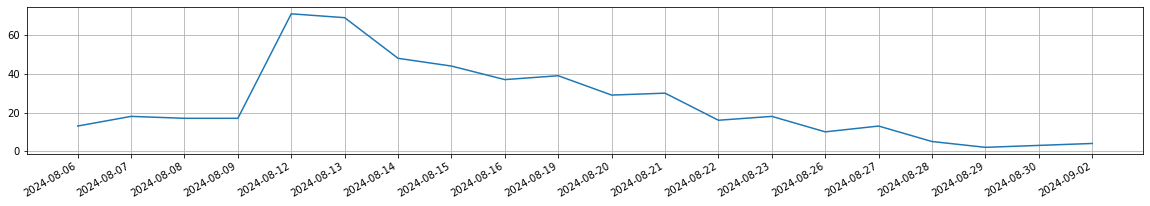

In [32]:
# gera_grafico(list_datas, d05_count)
gera_grafico(df_graficos['data'], df_graficos['qt_acoes_05'])

### Gráfico 10

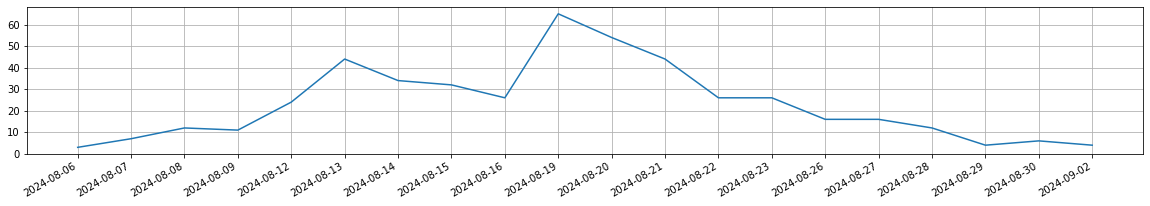

In [33]:
gera_grafico(df_graficos['data'], df_graficos['qt_acoes_10'])

### Gráfico 15

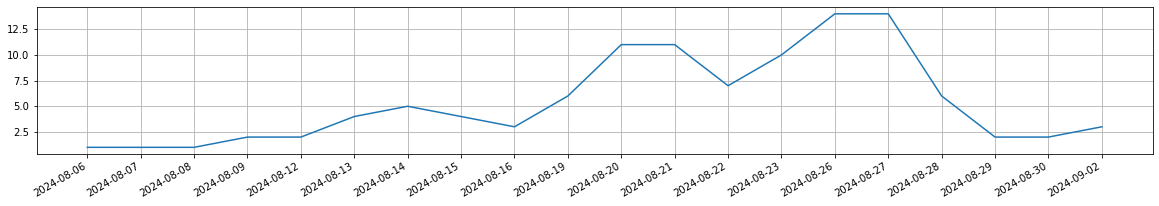

In [34]:
gera_grafico(df_graficos['data'], df_graficos['qt_acoes_15'])

### Gráfico 20

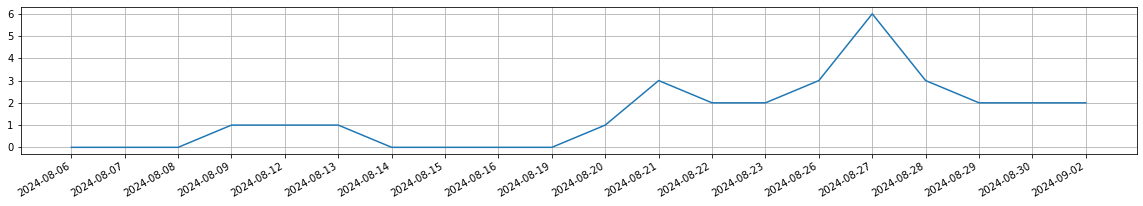

In [35]:
gera_grafico(df_graficos['data'], df_graficos['qt_acoes_20'])

### Gráfico 25

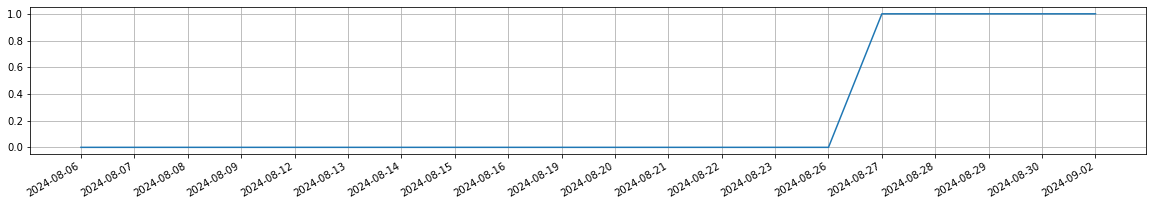

In [36]:
gera_grafico(df_graficos['data'], df_graficos['qt_acoes_25'])